# Example 1

> This example will demonstrate a TEF analysis carreid out for the Persian Gulf using data from Lorenz et al. (2020).
> 

In [1]:
from TotalExchangeFlow.tef_core import *
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
ds_winter = xr.open_dataset("./Programs/TotalExchangeFlow/data/SoH_2_2011_01.nc") #exchange flow in Strait of Hormuz winter
ds_summer = xr.open_dataset("./Programs/TotalExchangeFlow/data/SoH_2_2011_01.nc") #exchange flow in Strait of Hormuz summer
ds_2d_winter = xr.open_dataset("./Programs/TotalExchangeFlow/data/Surface_2011_01.nc") #SST and SSS winter
ds_2d_summer = xr.open_dataset("./Programs/TotalExchangeFlow/data/Surface_2011_08.nc") #SST and SSS summer

To get an overview about the area and the model domain, we first plot the Sea Surface Temperature (SST) and Sea Surface Salinity (SSS) during winter and summer (one daily mean value).

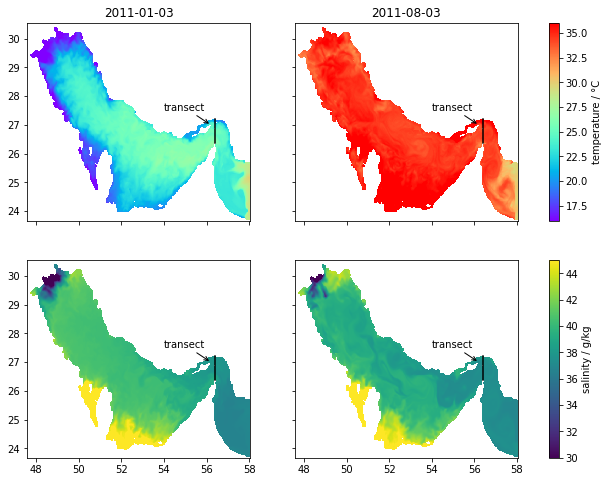

In [3]:
fig, ax = plt.subplots(2,2,sharex=True,sharey=True,figsize=(11,8))
ax=ax.ravel()
ax[0].set_title(str(ds_2d_winter.time[0].values)[:10])
ax[1].set_title(str(ds_2d_summer.time[0].values)[:10])
ax[0].pcolormesh(ds_2d_winter.lonc,ds_2d_winter.latc,ds_2d_winter.temp[0,0,:,:],vmin=16,vmax=36,cmap='rainbow')
tmp = ax[1].pcolormesh(ds_2d_summer.lonc,ds_2d_summer.latc,ds_2d_summer.temp[0,0,:,:],vmin=16,vmax=36,cmap='rainbow')
ax[2].pcolormesh(ds_2d_winter.lonc,ds_2d_winter.latc,ds_2d_winter.salt[0,0,:,:],vmin=30,vmax=45)
sal = ax[3].pcolormesh(ds_2d_summer.lonc,ds_2d_summer.latc,ds_2d_summer.salt[0,0,:,:],vmin=30,vmax=45)
plt.colorbar(tmp,ax=ax[:2],label='temperature / °C')
plt.colorbar(sal,ax=ax[2:],label='salinity / g/kg')
for axx in ax:
    axx.annotate('transect',xy=(56.2,27.),xytext=(54,27.5),arrowprops=dict(arrowstyle='->'))
    axx.plot([ds_winter.lonc.values,ds_winter.lonc.values],[ds_winter.latc.values[0],ds_winter.latc.values[-1]],color='k')

One can see that the Persian Gulf shows a large seasonal cycle in SST, varying from below 16°C in January to 
values greater than 36°C in August. The salinity shows regional differences with the Shatt Al Arab river plume in the north west and greatest surface salinities in the south.
Now let's explore the exchange flow. 

In [4]:
tef = TEF_object(ds = ds_winter)
tef.set_up()

**Note**: Minus sign for velx3d since negative velocities flow into the Glf and should be therefore counted as an inflow which is defined as positive!
**Note**: Calculation will around 3 minutes.

In [10]:
tef.calc_volume_transport(-tef.ds.velx3d, tef.ds.hn, tef.ds.dyc) 
tef.salt_transport = -tef.ds.salt*tef.ds.velx3d*tef.ds.hn*tef.ds.dyc
tef.temp_transport = -tef.ds.temp*tef.ds.velx3d*tef.ds.hn*tef.ds.dyc

out1d_vol_transport_s  = tef.sort_1dim(sort_by_variable=tef.ds.salt,
                       transport = tef.volume_transport,
                       N = 100)

out1d_salt_transport_s = tef.sort_1dim(sort_by_variable=tef.ds.salt,
                       transport = tef.salt_transport,
                       N = 100)

out1d_vol_transport_t  = tef.sort_1dim(sort_by_variable=tef.ds.temp,
                       transport = tef.volume_transport,
                       N = 100)

out1d_temp_transport_t = tef.sort_1dim(sort_by_variable=tef.ds.temp,
                       transport = tef.temp_transport,
                       N = 100)

out2d = tef.sort_2dim(sort_by_variable=tef.ds.salt,
                      sort_by_variable2=tef.ds.temp,
                      transport = tef.volume_transport,
                      N = 100)

time for 2d q computation: 88.39937210083008s
time for 2d Q computation: 174.49105858802795s
-4.656612873077393e-10 4.656612873077393e-10
time for new 2d Q computation: 0.22403478622436523s


Let's first have a look a the January 2011 mean results:

In [23]:
q_2d_mean = out2d.q2.mean('time')
q_s = out1d_vol_transport_s.q.mean('time')
q_t = out1d_vol_transport_t.q.mean('time')

Q_s = out1d_vol_transport_s.Q.mean('time')
Q_t = out1d_vol_transport_t.Q.mean('time')

Qs_s = out1d_salt_transport_s.Q.mean('time')
Qt_t = out1d_temp_transport_t.Q.mean('time')

bulk_vol_s = tef.calc_bulk_values(out1d_vol_transport_s.var_Q,Q_s)
bulk_vol_t = tef.calc_bulk_values(out1d_vol_transport_t.var_Q,Q_t)
bulk_salt_s = tef.calc_bulk_values(out1d_salt_transport_s.var_Q,Qs_s)
bulk_temp_t = tef.calc_bulk_values(out1d_temp_transport_t.var_Q,Qt_t)

print('Q_in: {} m3s-1 and Q_out {} m3s-1 from the isohaline TEF, Q_net: {}'
      .format(bulk_vol_s.Qin.values[0],bulk_vol_s.Qout.values[0],bulk_vol_s.Qin.values[0]+bulk_vol_s.Qin.values[0]))
print('Q_in: {} m3s-1 and Q_out {} m3s-1 from the isothermal TEF'
      .format(bulk_vol_t.Qin.values[0],bulk_vol_t.Qout.values[0]))

s_in  = bulk_salt_s.Qin / bulk_vol_s.Qin
s_out = bulk_salt_s.Qout / bulk_vol_s.Qout

t_in  = bulk_temp_t.Qin / bulk_vol_t.Qin
t_out  = bulk_temp_t.Qout / bulk_vol_t.Qout

print('s_in: {} g/kg and s_out: {} g/kg'.format(s_in.values[0],s_out.values[0]))
print('t_in: {} °C and t_out: {} °C'.format(t_in.values[0],t_out.values[0]))

Q_in: 235064.74767548358 m3s-1 and Q_out -170513.31682439466 m3s-1 from the isohaline TEF
Q_in: 175442.54011859308 m3s-1 and Q_out -110891.10926750416 m3s-1 from the isothermal TEF
s_in: 37.20742124239829 g/kg and s_out: 39.480090726688125 g/kg
t_in: 24.855765500257053 °C and t_out: 26.750089788751318 °C


The reason why the volume transports from the isohalien and the isothermal TEF analysis are different lies in the partial compensation in the 

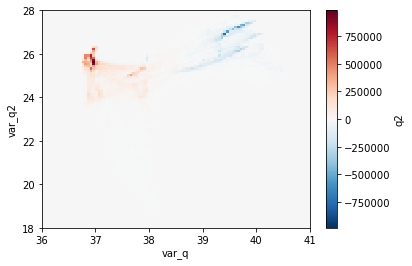

In [7]:
out2d.q2.mean("time").plot(x = "var_q",
                           y = "var_q2",
                           cmap = plt.cm.RdBu_r)

Text(0, 0.5, 'Salinity $[g/kg]$')

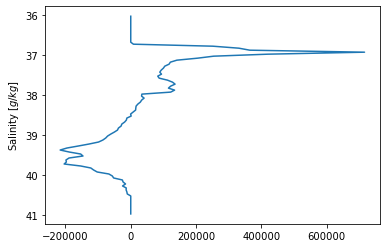

In [9]:
f, ax = plt.subplots(1)
plt.plot(out1d_salt.q.mean("time").values, out1d_salt.var_q.values)
ax.invert_yaxis()
ax.set_ylabel("Salinity $[g/kg]$")